In [4]:
'''
Workflow to obtain the df_weight used for Machine Learning and Catboost models as a .csv file
'''

import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import requests

def snowflake_connection():
    """
    Establishes a connection to Snowflake used for later reading and writing of tables
    
    Parameters:
    -----------
    none
    
    Returns:
    --------
    conn: The connection to Snowflake
    
    
    """
    load_dotenv()

    conn = snowflake.connector.connect(
        user=os.getenv("SNOWFLAKE_USER"),
        password = os.getenv("SNOWFLAKE_PWD"),
        account = 'jl41563.us-east-2.aws',
        role='GROUSE_ROLE_C_ANALYTICS',
        warehouse = 'GROUSE_WH',
        database = 'GROUSE_DEID_ANALYTICS_DB',
        schema = 'GROUSE_SEMA_wk50_52')
    
    return conn

conn = snowflake_connection()

def read_df_weight(conn, sql = ''' select *
                                from df_weight_test 
                                where pres_patid=any(select patid 
                                                    from all_info_clean 
                                                    where sema_weeks>=26);'''):
    '''
    Reads the prescriptions_data table from snowflake into a DataFrame
    
    Parameters:
    -----------
    conn: Snowflake connection
    sql: SQL query string
    
    
    Returns:
    -------
    df_prescriptions: Nx3 DataFrame 
                        Column 1: PATID
                        Column 2: DATE
                        Column 3: RXNORM_CUI
                        Column 4: INGREDIENT'''
    
    cur = conn.cursor()
    df_weight = cur.execute(sql).fetch_pandas_all()
    return df_weight

df_weight = read_df_weight(conn)
print(df_weight.shape)

# fill all NaN values with 0
df_weight.fillna(0, inplace=True)
print(df_weight.shape)

# select only string columns
string_cols = df_weight.select_dtypes(include=['object']).columns

# drop string columns
df_weight.drop(string_cols, axis=1, inplace=True)

print(df_weight.shape)
df_weight.head()

(539, 1397)
(539, 1397)
(539, 1395)


,'1','10','100','101','102','103','104','105','106','107',...,'zoledronic acid','zolmitriptan','zolpidem','zonisamide',SEX,RACE,AGE,INIT_WT,SEMA_WEEKS,LABEL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,36,213.0,64,-0.032864
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,65,260.0,63,-0.280769
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,59,354.0,109,-0.053672
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,59,182.0,32,-0.131868
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,68,168.0,54,-0.047619


In [5]:
df_weight.to_csv('df_weight_wk50_52v2', index=False)

In [6]:
#Catboost - my own hyperparameter search - improved!a - 10% Weight Loss catboost
#Here is the more final slightly more limited version
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils.class_weight import compute_class_weight



def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    #print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc 




def catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs):
    cat_aucs = []
    params = []
    for dep in depths:
        for lr in learning_rates:
            for itr in iterations:
                for l2 in l2_leaf_regs:
                    X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, itr, 
                                                                                                lr, dep, l2)
                    cat_aucs.append(cat_auc)
                    params.append([dep, lr, itr, l2])
                    print(cat_auc)
                    print(itr, lr, dep, l2)


    print('max_auc: ', max(cat_aucs))
    cat_aucs = np.array(cat_aucs)
    print('best parameters: ', params[np.argmax(cat_aucs)])
    
    return params[np.argmax(cat_aucs)]

depths = [2,3,4,6]
learning_rates = [0.03, 0.1, 0.3, 0.5]
iterations = [25, 50, 75, 100, 150]

l2_leaf_regs = [0.5, 1, 5]

best_params = catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs)

0.6046195652173914
25 0.03 2 0.5
0.5545419254658385
25 0.03 2 1
0.6488742236024844
25 0.03 2 5
0.641304347826087
50 0.03 2 0.5
0.6333462732919255
50 0.03 2 1
0.7288431677018634
50 0.03 2 5
0.6612965838509316
75 0.03 2 0.5
0.6444099378881988
75 0.03 2 1
0.6570263975155279
75 0.03 2 5
0.6721661490683231
100 0.03 2 0.5
0.6579968944099379
100 0.03 2 1
0.6814829192546583
100 0.03 2 5
0.6659549689440993
150 0.03 2 0.5
0.6506211180124223
150 0.03 2 1
0.671972049689441
150 0.03 2 5
0.6370341614906831
25 0.1 2 0.5
0.6119953416149069
25 0.1 2 1
0.6583850931677019
25 0.1 2 5
0.6684782608695653
50 0.1 2 0.5
0.6762422360248447
50 0.1 2 1
0.6591614906832298
50 0.1 2 5
0.6950698757763975
75 0.1 2 0.5
0.6962344720496895
75 0.1 2 1
0.6801242236024845
75 0.1 2 5
0.6805124223602484
100 0.1 2 0.5
0.6896350931677019
100 0.1 2 1
0.6744953416149069
100 0.1 2 5
0.669836956521739
150 0.1 2 0.5
0.6756599378881988
150 0.1 2 1
0.6921583850931676
150 0.1 2 5
0.5673524844720497
25 0.3 2 0.5
0.6302406832298136
25 0.

Catboost: ROC AUC=0.732
Sensitivity: 0.17
Specificity: 0.96
Accuracy: 0.82


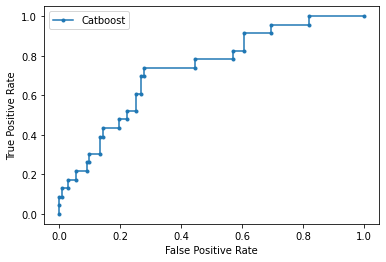

In [7]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 100, 0.3, 4, 5)

Catboost: ROC AUC=0.732
Sensitivity: 0.17
Specificity: 0.96
Accuracy: 0.82


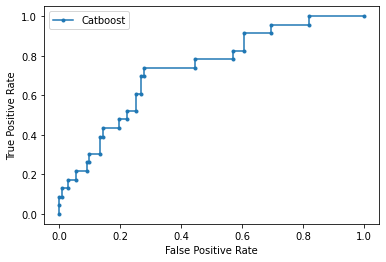

In [8]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 100, 0.3, 4, 5)

In [12]:
'''
Implementing the Repeated Cross-Validations - 10%
'''
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap


def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def fit_catboost_cv(df_weight, dep, lr, itr, l2, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = CatBoostClassifier(iterations=itr,
                                learning_rate=lr,
                                depth=dep, 
                                l2_leaf_reg = l2,
                                verbose=False)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            cat_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            cat_probs = cat_probs[:, 1]
            
            # calculate scores
            cat_auc = roc_auc_score(y_test, cat_probs)

            # summarize scores
            print('Catboost: ROC AUC=%.3f' % (cat_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = fit_catboost_cv(df_weight, 4, 0.3, 100, 5, shap_values_per_cv, random_states) 


------------ CV Repeat number: 0

------ Fold Number: 0
Catboost: ROC AUC=0.691

------ Fold Number: 1
Catboost: ROC AUC=0.494

------ Fold Number: 2
Catboost: ROC AUC=0.732

------ Fold Number: 3
Catboost: ROC AUC=0.610

------ Fold Number: 4
Catboost: ROC AUC=0.637

------------ CV Repeat number: 1

------ Fold Number: 0
Catboost: ROC AUC=0.599

------ Fold Number: 1
Catboost: ROC AUC=0.658

------ Fold Number: 2
Catboost: ROC AUC=0.612

------ Fold Number: 3
Catboost: ROC AUC=0.587

------ Fold Number: 4
Catboost: ROC AUC=0.625

------------ CV Repeat number: 2

------ Fold Number: 0
Catboost: ROC AUC=0.655

------ Fold Number: 1
Catboost: ROC AUC=0.623

------ Fold Number: 2
Catboost: ROC AUC=0.787

------ Fold Number: 3
Catboost: ROC AUC=0.530

------ Fold Number: 4
Catboost: ROC AUC=0.579

------------ CV Repeat number: 3

------ Fold Number: 0
Catboost: ROC AUC=0.767

------ Fold Number: 1
Catboost: ROC AUC=0.659

------ Fold Number: 2
Catboost: ROC AUC=0.591

------ Fold Numbe

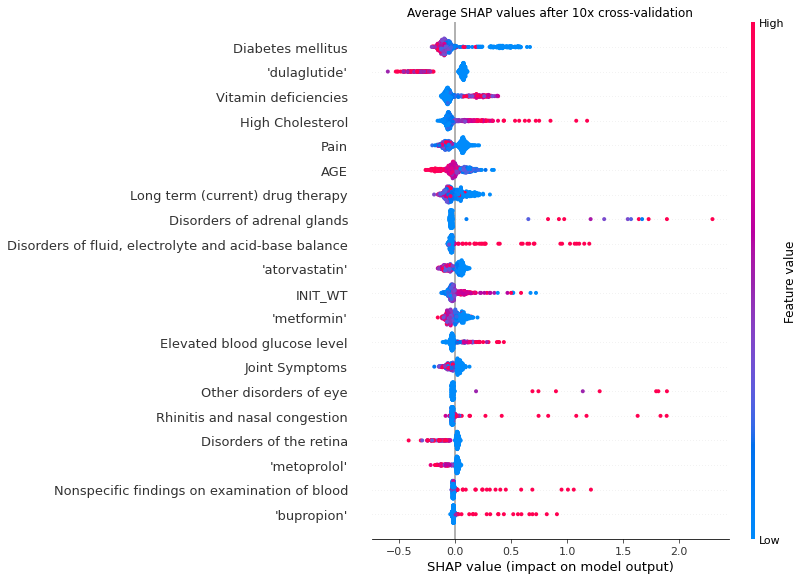

In [13]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,1:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)
    
average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

X = X.rename(columns={"'232'": "Vitamin deficiencies", 
                      "'202'": "Diabetes mellitus", 
                      "'239'": "High Cholesterol", 
                      "'204'": "Elevated blood glucose level",
                      "'256'": "Disorders of fluid, electrolyte and acid-base balance",
                      "'208'": "Disorders of parathyroid gland",
                      "'401'": "Hypertension",
                      "'809'": "Pain",
                      "'713'": "Joint Symptoms",
                      "'337'": "Polyneuropathies",
                      "'236'": "Overweight and obesity",
                      "'211'": "Disorders of adrenal glands",
                      "'374'": "Disorders of the retina",
                      "'389'": "Other disorders of eye",
                      "'977'": "Long term (current) drug therapy",
                      "'164'": "Anemia",
                      "'230'": "Malnutrition and underweight",
                      "'431'": "Stroke and transient cerebral ischemic attacks",
                      "'829'": "Nonspecific findings on examination of blood",
                      "'463'": "Rhinitis and nasal congestion",
                      "'308'": "Signs and symptoms involving emotional state",
                      "'465'": "Pharyngitis"
                     })
shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')
plt.savefig('catboost_cv_shap.pdf')

In [2]:
import pandas as pd

df_weight_binary = pd.read_csv('df_weight_wk50_52v2')

# Select the numeric columns except for the last one
numeric_cols = df_weight_binary.select_dtypes(include=['number']).columns[:-6]

# Convert non-zero elements to 1 for each numeric column
for col in numeric_cols:
    df_weight_binary[col] = df_weight_binary[col].apply(lambda x: 1 if x != 0 else 0)
    
    
# Drop rows where 'semaglutide' has a value of zero
#df_weight_binary = df_weight_binary[df_weight_binary["'semaglutide'"] != 0]

# Drop the 'semaglutide' column from the dataframe
df_weight_binary.drop("'semaglutide'", axis=1, inplace=True)


print(df_weight_binary.shape)
df_weight_binary.head()

(539, 1394)


,'1','10','100','101','102','103','104','105','106','107',...,'zoledronic acid','zolmitriptan','zolpidem','zonisamide',SEX,RACE,AGE,INIT_WT,SEMA_WEEKS,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,36,213.0,64,-0.032864
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0,1.0,65,260.0,63,-0.280769
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,59,354.0,109,-0.053672
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,59,182.0,32,-0.131868
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.0,1.0,68,168.0,54,-0.047619


In [3]:
df_weight = df_weight_binary

In [39]:
#Catboost - my own hyperparameter search - improved!a - 10% Weight Loss catboost
#Here is the more final slightly more limited version
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils.class_weight import compute_class_weight



def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False,
                              scale_pos_weight=0.85)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    #print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc 




def catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs):
    cat_aucs = []
    params = []
    for dep in depths:
        for lr in learning_rates:
            for itr in iterations:
                for l2 in l2_leaf_regs:
                    X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, itr, 
                                                                                                lr, dep, l2)
                    cat_aucs.append(cat_auc)
                    params.append([dep, lr, itr, l2])
                    print(cat_auc)
                    print(itr, lr, dep, l2)


    print('max_auc: ', max(cat_aucs))
    cat_aucs = np.array(cat_aucs)
    print('best parameters: ', params[np.argmax(cat_aucs)])
    
    return params[np.argmax(cat_aucs)]

depths = [2,3,4,6]
learning_rates = [0.03, 0.1, 0.3, 0.5]
iterations = [25, 50, 75, 100, 150]

l2_leaf_regs = [0.5, 1, 5]

best_params = catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs)

0.6160714285714286
25 0.03 2 0.5
0.6952639751552796
25 0.03 2 1
0.5712344720496894
25 0.03 2 5
0.6230590062111802
50 0.03 2 0.5
0.6521739130434783
50 0.03 2 1
0.6290760869565217
50 0.03 2 5
0.6362577639751552
75 0.03 2 0.5
0.6630434782608695
75 0.03 2 1
0.6197593167701864
75 0.03 2 5
0.6836180124223602
100 0.03 2 0.5
0.6657608695652174
100 0.03 2 1
0.6486801242236024
100 0.03 2 5
0.7146739130434784
150 0.03 2 0.5
0.6946816770186335
150 0.03 2 1
0.6673136645962733
150 0.03 2 5
0.6977872670807453
25 0.1 2 0.5
0.6267468944099379
25 0.1 2 1
0.6896350931677019
25 0.1 2 5
0.7160326086956522
50 0.1 2 0.5
0.6180124223602484
50 0.1 2 1
0.7228260869565217
50 0.1 2 5
0.7261257763975154
75 0.1 2 0.5
0.6779891304347826
75 0.1 2 1
0.7276785714285714
75 0.1 2 5
0.7630046583850931
100 0.1 2 0.5
0.71875
100 0.1 2 1
0.7311723602484471
100 0.1 2 5
0.7680512422360248
150 0.1 2 0.5
0.7321428571428571
150 0.1 2 1
0.7381599378881987
150 0.1 2 5
0.702639751552795
25 0.3 2 0.5
0.6832298136645962
25 0.3 2 1
0.7

Catboost: ROC AUC=0.827
Sensitivity: 0.17
Specificity: 0.99
Accuracy: 0.85


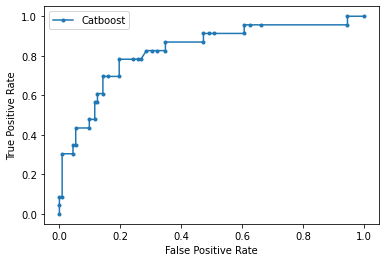

In [41]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False,
                              scale_pos_weight = 0.85)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 75, 0.5, 2, 5)

In [16]:
#Catboost - my own hyperparameter search - improved!a - 10% Weight Loss catboost
#Here is the more final slightly more limited version
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils.class_weight import compute_class_weight



def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    #print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc 




def catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs):
    cat_aucs = []
    params = []
    for dep in depths:
        for lr in learning_rates:
            for itr in iterations:
                for l2 in l2_leaf_regs:
                    X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, itr, 
                                                                                                lr, dep, l2)
                    cat_aucs.append(cat_auc)
                    params.append([dep, lr, itr, l2])
                    print(cat_auc)
                    print(itr, lr, dep, l2)


    print('max_auc: ', max(cat_aucs))
    cat_aucs = np.array(cat_aucs)
    print('best parameters: ', params[np.argmax(cat_aucs)])
    
    return params[np.argmax(cat_aucs)]

depths = [2,3,4,6]
learning_rates = [0.03, 0.1, 0.3, 0.5]
iterations = [25, 50, 75, 100, 150]

l2_leaf_regs = [0.5, 1, 5]

best_params = catboost_grid_search(depths, learning_rates, iterations, l2_leaf_regs)

0.6861413043478262
25 0.03 2 0.5
0.640527950310559
25 0.03 2 1
0.6655667701863354
25 0.03 2 5
0.6968167701863355
50 0.03 2 0.5
0.6207298136645963
50 0.03 2 1
0.6636257763975156
50 0.03 2 5
0.6680900621118012
75 0.03 2 0.5
0.6294642857142858
75 0.03 2 1
0.6378105590062111
75 0.03 2 5
0.6919642857142857
100 0.03 2 0.5
0.6805124223602484
100 0.03 2 1
0.6801242236024845
100 0.03 2 5
0.6886645962732919
150 0.03 2 0.5
0.689052795031056
150 0.03 2 1
0.702639751552795
150 0.03 2 5
0.6896350931677019
25 0.1 2 0.5
0.6152950310559007
25 0.1 2 1
0.6653726708074534
25 0.1 2 5
0.6931288819875775
50 0.1 2 0.5
0.6603260869565218
50 0.1 2 1
0.6917701863354037
50 0.1 2 5
0.7133152173913043
75 0.1 2 0.5
0.6729425465838509
75 0.1 2 1
0.6964285714285715
75 0.1 2 5
0.7142857142857144
100 0.1 2 0.5
0.6785714285714285
100 0.1 2 1
0.7084627329192547
100 0.1 2 5
0.7142857142857143
150 0.1 2 0.5
0.6836180124223602
150 0.1 2 1
0.7251552795031057
150 0.1 2 5
0.6677018633540374
25 0.3 2 0.5
0.7129270186335405
25 0.

Catboost: ROC AUC=0.810
Sensitivity: 0.04
Specificity: 1.00
Accuracy: 0.84


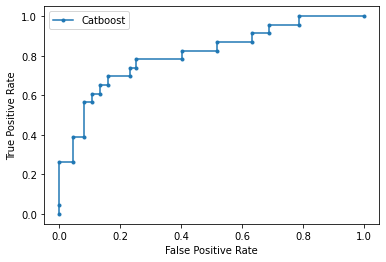

In [17]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 75, 0.1, 3, 1)

Catboost: ROC AUC=0.781
Sensitivity: 0.17
Specificity: 0.99
Accuracy: 0.85


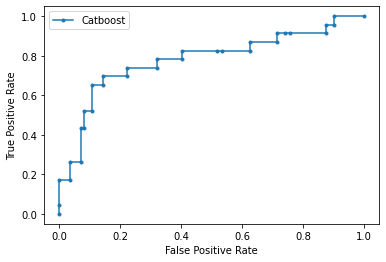

In [20]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 50, 0.5, 3, 5)

Catboost: ROC AUC=0.808
Sensitivity: 0.22
Specificity: 0.98
Accuracy: 0.85


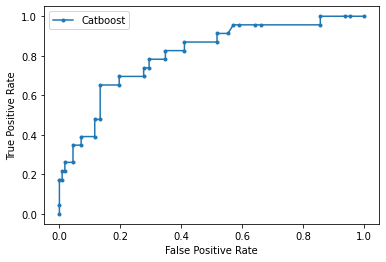

In [22]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 50, 0.3, 3, 0.5)

Matplotlib is building the font cache; this may take a moment.


Catboost: ROC AUC=0.808
Sensitivity: 0.217
Specificity: 0.982
Accuracy: 0.852


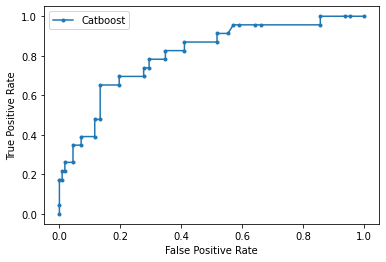

In [4]:
#10% Loss Best Catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def fit_catboost_classifier4(df_weight, itr, lr, dep, l2):
    '''
    Function that fits Catboost classifier, taking in the individual parameters
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)
    
    
    
    model = CatBoostClassifier(iterations=itr,
                              learning_rate=lr,
                              depth=dep, 
                              l2_leaf_reg = l2,
                               verbose=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    cat_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    cat_probs = cat_probs[:, 1]
    
    # calculate scores
    cat_auc = roc_auc_score(y_test, cat_probs)
    
    # summarize scores
    print('Catboost: ROC AUC=%.3f' % (cat_auc))
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    # print results
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Accuracy: {accuracy:.3f}")

    
    # calculate roc curves
    cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
    
    # plot the roc curve for the model
    plt.plot(cat_fpr, cat_tpr, marker='.', label='Catboost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('catboost_auroc.pdf', dpi=300)
    plt.show()
    
    
    return X_train, X_test, y_train, y_test, model, cat_auc


X_train, X_test, y_train, y_test, model, cat_auc = fit_catboost_classifier4(df_weight, 50, 0.3, 3, 0.5)

In [6]:
import numpy as np

def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, ci=95):
    aucs = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstraps):
        indices = rng.choice(len(y_true), len(y_true), replace=True)
        sample_true = y_true.iloc[indices]
        sample_pred = y_pred[indices]
        aucs.append(roc_auc_score(sample_true, sample_pred))
    lower = (100 - ci) / 2
    upper = 100 - lower
    return np.percentile(aucs, lower), np.percentile(aucs, upper)

# predict probabilities
cat_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
cat_probs = cat_probs[:, 1]

# calculate scores
cat_auc = roc_auc_score(y_test, cat_probs)
cat_lower, cat_upper = bootstrap_auc(y_test, cat_probs)

# summarize scores
print(f'Catboost: ROC AUC={cat_auc:.3f} ( CI: [{cat_lower:.3f}, {cat_upper:.3f}])')


Catboost: ROC AUC=0.808 ( CI: [0.694, 0.901])


In [28]:
'''
Implementing the Repeated Cross-Validations - 10%
'''
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap

df_weight.drop('SEMA_WEEKS', axis=1, inplace=True)

def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def fit_catboost_cv(df_weight, dep, lr, itr, l2, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,1:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = CatBoostClassifier(iterations=itr,
                                learning_rate=lr,
                                depth=dep, 
                                l2_leaf_reg = l2,
                                verbose=False)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            cat_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            cat_probs = cat_probs[:, 1]
            
            # calculate scores
            cat_auc = roc_auc_score(y_test, cat_probs)

            # summarize scores
            print('Catboost: ROC AUC=%.3f' % (cat_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = fit_catboost_cv(df_weight, 3, 0.3, 50, 0.5, shap_values_per_cv, random_states) 


------------ CV Repeat number: 0

------ Fold Number: 0
Catboost: ROC AUC=0.567

------ Fold Number: 1
Catboost: ROC AUC=0.616

------ Fold Number: 2
Catboost: ROC AUC=0.697

------ Fold Number: 3
Catboost: ROC AUC=0.648

------ Fold Number: 4
Catboost: ROC AUC=0.671

------------ CV Repeat number: 1

------ Fold Number: 0
Catboost: ROC AUC=0.611

------ Fold Number: 1
Catboost: ROC AUC=0.621

------ Fold Number: 2
Catboost: ROC AUC=0.676

------ Fold Number: 3
Catboost: ROC AUC=0.592

------ Fold Number: 4
Catboost: ROC AUC=0.664

------------ CV Repeat number: 2

------ Fold Number: 0
Catboost: ROC AUC=0.651

------ Fold Number: 1
Catboost: ROC AUC=0.658

------ Fold Number: 2
Catboost: ROC AUC=0.736

------ Fold Number: 3
Catboost: ROC AUC=0.586

------ Fold Number: 4
Catboost: ROC AUC=0.735

------------ CV Repeat number: 3

------ Fold Number: 0
Catboost: ROC AUC=0.686

------ Fold Number: 1
Catboost: ROC AUC=0.711

------ Fold Number: 2
Catboost: ROC AUC=0.589

------ Fold Numbe

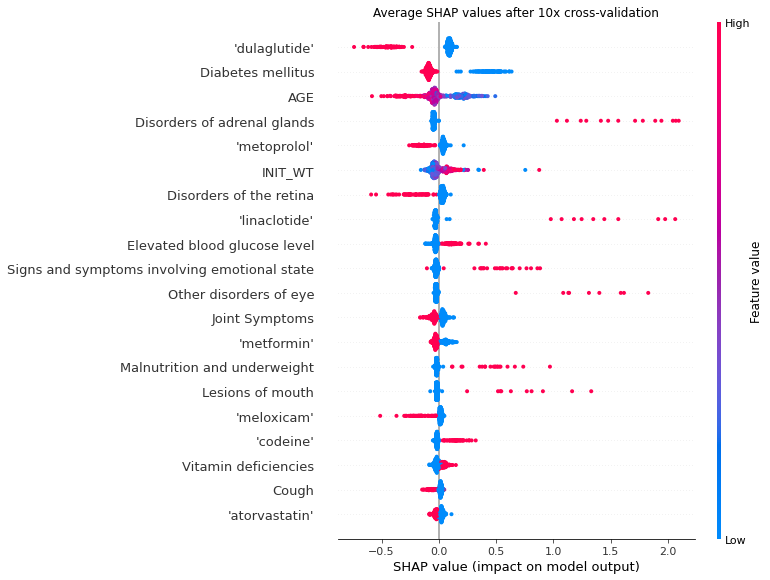

In [37]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,1:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)
    
average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

X = X.rename(columns={"'232'": "Vitamin deficiencies", 
                      "'202'": "Diabetes mellitus", 
                      "'239'": "High Cholesterol", 
                      "'204'": "Elevated blood glucose level",
                      "'256'": "Disorders of fluid, electrolyte and acid-base balance",
                      "'208'": "Disorders of parathyroid gland",
                      "'401'": "Hypertension",
                      "'809'": "Pain",
                      "'713'": "Joint Symptoms",
                      "'337'": "Polyneuropathies",
                      "'236'": "Overweight and obesity",
                      "'211'": "Disorders of adrenal glands",
                      "'374'": "Disorders of the retina",
                      "'389'": "Other disorders of eye",
                      "'977'": "Long term (current) drug therapy",
                      "'164'": "Anemia",
                      "'230'": "Malnutrition and underweight",
                      "'431'": "Stroke and transient cerebral ischemic attacks",
                      "'829'": "Nonspecific findings on examination of blood",
                      "'463'": "Rhinitis and nasal congestion",
                      "'308'": "Signs and symptoms involving emotional state",
                      "'465'": "Pharyngitis",
                      "'507'": "Lesions of mouth",
                      "'801'": "Cough"
                     })
shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')
plt.savefig('catboost_cv_shap_revised.pdf', bbox_inches='tight')

In [35]:
import statsmodels.api as sm
import numpy as np
import warnings
#warnings.filterwarnings("ignore")


#Clean the data to include only the SHAP features
shap_features = ["'dulaglutide'", 
                 "Diabetes mellitus", 
                 "AGE",
                 "Disorders of adrenal glands",
                 "'metoprolol'",
                 "INIT_WT",
                 "Disorders of the retina",
                 "'linaclotide'",
                 "Elevated blood glucose level", 
                 "Signs and symptoms involving emotional state", 
                 "Other disorders of eye",
                 "Joint Symptoms", 
                 "'metformin'",
                 "Malnutrition and underweight",
                 "Lesions of mouth",
                 "'meloxicam'",
                 "'codeine'",
                 "Vitamin deficiencies",
                 "Cough",
                 "'atorvastatin'", 
                 "LABEL"
                ]
df_weight_lr = df_weight.rename(columns={"'232'": "Vitamin deficiencies", 
                      "'202'": "Diabetes mellitus", 
                      "'239'": "High Cholesterol", 
                      "'204'": "Elevated blood glucose level",
                      "'256'": "Disorders of fluid, electrolyte and acid-base balance",
                      "'208'": "Disorders of parathyroid gland",
                      "'401'": "Hypertension",
                      "'809'": "Pain",
                      "'713'": "Joint Symptoms",
                      "'337'": "Polyneuropathies",
                      "'236'": "Overweight and obesity",
                      "'211'": "Disorders of adrenal glands",
                      "'374'": "Disorders of the retina",
                      "'389'": "Other disorders of eye",
                      "'977'": "Long term (current) drug therapy",
                      "'164'": "Anemia",
                      "'230'": "Malnutrition and underweight",
                      "'431'": "Stroke and transient cerebral ischemic attacks",
                      "'829'": "Nonspecific findings on examination of blood",
                      "'463'": "Rhinitis and nasal congestion",
                      "'308'": "Signs and symptoms involving emotional state",
                      "'465'": "Pharyngitis",
                      "'507'": "Lesions of mouth",
                      "'801'": "Cough"
                     })
df_weight_lr = df_weight_lr[shap_features]

#Splitting into predictor and label categories
X = df_weight_lr.iloc[:,:-1]
y = [1 if a<-.1 else 0 for a in df_weight_lr.iloc[:,-1]]

model = sm.Logit(y, X).fit()

params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))
print(len(shap_features))

Optimization terminated successfully.
         Current function value: 0.340068
         Iterations 7
                                                    5%         95%  Odds Ratio
'dulaglutide'                                 0.088735    0.749501    0.257890
Diabetes mellitus                             0.219571    0.867845    0.436525
AGE                                           0.967433    0.998833    0.983008
Disorders of adrenal glands                   6.027814  107.449053   25.449615
'metoprolol'                                  0.184265    1.024063    0.434395
INIT_WT                                       0.997636    1.004754    1.001189
Disorders of the retina                       0.069906    0.727453    0.225507
'linaclotide'                                 2.539505   87.968116   14.946419
Elevated blood glucose level                  1.282578    4.201492    2.321367
Signs and symptoms involving emotional state  0.900996    6.475157    2.415386
Other disorders of eye       

In [42]:
'''
Gradient Boosting Classifier - 10% Weight loss search
'''

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

n_estimators = [25, 50, 100, 200]
learning_rates = [0.01, 0.05, 0.03, 0.1, 0.2]
max_depths = [2,3,4,5,6]



def fit_gbr(df_weight, n_est, lr, md):
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)

    y = df_weight.iloc[:,-1]
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y_binary, random_state=42)  

    gbr_clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, random_state=2)
    gbr_clf.fit(X_train, y_train)

    y_pred = gbr_clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)


    # predict probabilities
    gbr_probs = gbr_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    gbr_probs = gbr_probs[:, 1]

    # calculate scores
    gbr_auc = roc_auc_score(y_test, gbr_probs)

    # summarize scores
    print('Gradient Boosting: ROC AUC=%.3f' % (gbr_auc))
    
    return gbr_auc

aucs = []
params = []

for n_est in n_estimators:
    for lr in learning_rates:
        for md in max_depths:
            gbr_auc = fit_gbr(df_weight, n_est, lr, md)
            params.append([n_est, lr, md])
            aucs.append(gbr_auc)
            
print('max_auc: ', max(aucs))
aucs = np.array(aucs)
print('best parameters: ', params[np.argmax(aucs)])  

Gradient Boosting: ROC AUC=0.536
Gradient Boosting: ROC AUC=0.598
Gradient Boosting: ROC AUC=0.641
Gradient Boosting: ROC AUC=0.611
Gradient Boosting: ROC AUC=0.678
Gradient Boosting: ROC AUC=0.598
Gradient Boosting: ROC AUC=0.619
Gradient Boosting: ROC AUC=0.618
Gradient Boosting: ROC AUC=0.637
Gradient Boosting: ROC AUC=0.633
Gradient Boosting: ROC AUC=0.649
Gradient Boosting: ROC AUC=0.617
Gradient Boosting: ROC AUC=0.634
Gradient Boosting: ROC AUC=0.599
Gradient Boosting: ROC AUC=0.640
Gradient Boosting: ROC AUC=0.708
Gradient Boosting: ROC AUC=0.641
Gradient Boosting: ROC AUC=0.610
Gradient Boosting: ROC AUC=0.633
Gradient Boosting: ROC AUC=0.669
Gradient Boosting: ROC AUC=0.728
Gradient Boosting: ROC AUC=0.667
Gradient Boosting: ROC AUC=0.628
Gradient Boosting: ROC AUC=0.637
Gradient Boosting: ROC AUC=0.656
Gradient Boosting: ROC AUC=0.606
Gradient Boosting: ROC AUC=0.588
Gradient Boosting: ROC AUC=0.645
Gradient Boosting: ROC AUC=0.611
Gradient Boosting: ROC AUC=0.645
Gradient B

Gradient Boosting: ROC AUC=0.751


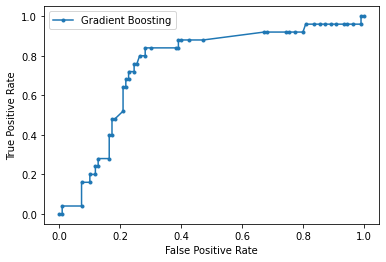

In [43]:
#10% Loss Best Catboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def fit_gbr(df_weight, n_est, lr, md):
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)

    y = df_weight.iloc[:,-1]
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)  

    gbr_clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, random_state=2)
    gbr_clf.fit(X_train, y_train)

    y_pred = gbr_clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)


    # predict probabilities
    gbr_probs = gbr_clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    gbr_probs = gbr_probs[:, 1]

    # calculate scores
    gbr_auc = roc_auc_score(y_test, gbr_probs)
    
    # summarize scores
    print('Gradient Boosting: ROC AUC=%.3f' % (gbr_auc))
    
    # calculate roc curves
    gbr_fpr, gbr_tpr, _ = roc_curve(y_test, gbr_probs)
    
    # plot the roc curve for the model
    plt.plot(gbr_fpr, gbr_tpr, marker='.', label='Gradient Boosting')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('gb_auroc.pdf', dpi=300)
    plt.show()
    
    return X_train, X_test, y_train, y_test, gbr_clf, gbr_auc


X_train, X_test, y_train, y_test, model, gbr_auc = fit_gbr(df_weight, 100, 0.1, 2)

In [57]:
'''
Implementing the Repeated Cross-Validations - 10% loss
'''
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() < 10], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def gbr_cv(df_weight, n_est, lr, md, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = GradientBoostingClassifier(n_estimators=n_est, max_depth=md, learning_rate=lr, random_state=2)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            gbr_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            gbr_probs = gbr_probs[:, 1]
            
            # calculate scores
            gbr_auc = roc_auc_score(y_test, gbr_probs)

            # summarize scores
            print('Gradient Boosting: ROC AUC=%.3f' % (gbr_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = gbr_cv(df_weight, 50, 0.01, 5, shap_values_per_cv, random_states)


------------ CV Repeat number: 0

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.708

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.584

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.744

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.587

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.607

------------ CV Repeat number: 1

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.588

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.647

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.652

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.731

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.589

------------ CV Repeat number: 2

------ Fold Number: 0
Gradient Boosting: ROC AUC=0.592

------ Fold Number: 1
Gradient Boosting: ROC AUC=0.552

------ Fold Number: 2
Gradient Boosting: ROC AUC=0.606

------ Fold Number: 3
Gradient Boosting: ROC AUC=0.563

------ Fold Number: 4
Gradient Boosting: ROC AUC=0.638

------------ CV Repeat number: 3

------ Fold Number: 0
G

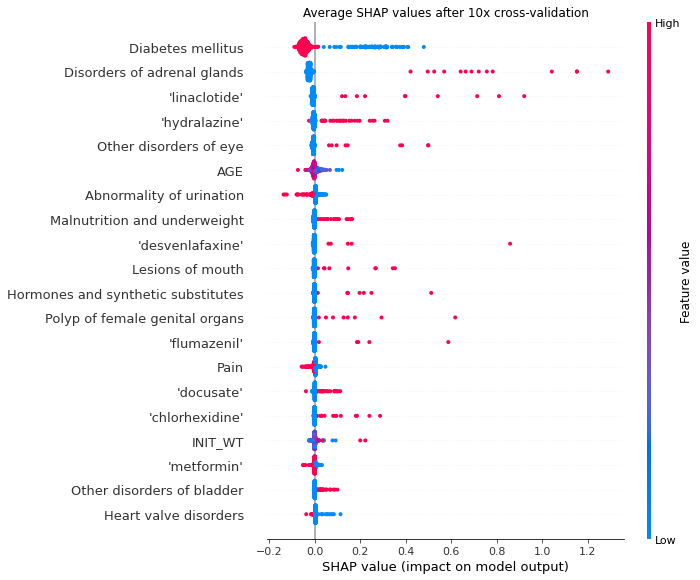

In [60]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)
X = X.rename(columns={"'232'": "Vitamin deficiencies", 
                      "'202'": "Diabetes mellitus", 
                      "'239'": "High Cholesterol", 
                      "'204'": "Elevated blood glucose level",
                      "'256'": "Disorders of fluid, electrolyte and acid-base balance",
                      "'208'": "Disorders of parathyroid gland",
                      "'401'": "Hypertension",
                      "'809'": "Pain",
                      "'713'": "Joint Symptoms",
                      "'337'": "Polyneuropathies",
                      "'236'": "Overweight and obesity",
                      "'211'": "Disorders of adrenal glands",
                      "'374'": "Disorders of the retina",
                      "'389'": "Other disorders of eye",
                      "'977'": "Long term (current) drug therapy",
                      "'164'": "Anemia",
                      "'230'": "Malnutrition and underweight",
                      "'431'": "Stroke and transient cerebral ischemic attacks",
                      "'829'": "Nonspecific findings on examination of blood",
                      "'463'": "Rhinitis and nasal congestion",
                      "'308'": "Signs and symptoms involving emotional state",
                      "'465'": "Pharyngitis",
                      "'507'": "Lesions of mouth",
                      "'801'": "Cough",
                      "'596'": "Other disorders of bladder",
                      "'676'": "Hypertrophic conditions of skin",
                      "'483'": "Pleural effusion",
                      "'594'": "Abnormality of urination",
                      "'961'": "Hormones and synthetic substitutes",
                      "'622'": "Polyp of female genital organs",
                      "'413'": "Heart valve disorders"
                     })
average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)


shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')
plt.savefig('gb_cv_shap.pdf', dpi=300, bbox_inches = "tight")

In [50]:
'''10% XGBoost Search'''
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt


def fit_xgb_classifier3(df_weight, lr, d, gam, a, sub, spw):
    
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    
    y = df_weight.iloc[:,-1]
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
       
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)   
    
    
    model = XGBClassifier(max_depth=d, subsample=sub, scale_pos_weight=spw, learning_rate=lr, gamma=gam, 
                          alpha=a, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    # predict probabilities
    xgb_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    xgb_probs = xgb_probs[:, 1]
    
    # calculate scores
    xgb_auc = roc_auc_score(y_test, xgb_probs)
    
    # summarize scores
    print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
    
    
    return X_train, X_test, y_train, y_test, model, xgb_auc

def xgboost_grid_search():
    '''
    Personal function written to perform xgboost grid search
    '''
    learning_rates = [0.01, 0.03, 0.1]
    max_depths = [2, 3, 4, 5, 6]
    gammas = [0, .1]
    alphas = [0, 0.1, 0.5]
    subsamples = [0.5, 0.75, 1]

    aucs = []
    params = []
    spw=0.8
    for lr in learning_rates:
        for d in max_depths:
            for gam in gammas:
                for a in alphas:
                    for sub in subsamples:
                        #print(lr,d, gam, a, sub, spw)
                        X_train, X_test, y_train, y_test, model, xgb_auc = fit_xgb_classifier3(df_weight,lr, 
                                                                                           d, gam, a, sub, spw)
                        aucs.append(xgb_auc)
                        params.append([lr, d, gam, a, sub, spw])

    print('max_auc: ', max(aucs))
    aucs = np.array(aucs)
    print('best parameters: ', params[np.argmax(aucs)])
    
    return params[np.argmax(aucs)]

best_params = xgboost_grid_search()

XGBoost: ROC AUC=0.711
XGBoost: ROC AUC=0.745
XGBoost: ROC AUC=0.728
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.741
XGBoost: ROC AUC=0.723
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.740
XGBoost: ROC AUC=0.716
XGBoost: ROC AUC=0.711
XGBoost: ROC AUC=0.745
XGBoost: ROC AUC=0.728
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.741
XGBoost: ROC AUC=0.723
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.740
XGBoost: ROC AUC=0.716
XGBoost: ROC AUC=0.717
XGBoost: ROC AUC=0.750
XGBoost: ROC AUC=0.754
XGBoost: ROC AUC=0.719
XGBoost: ROC AUC=0.746
XGBoost: ROC AUC=0.759
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.743
XGBoost: ROC AUC=0.757
XGBoost: ROC AUC=0.717
XGBoost: ROC AUC=0.750
XGBoost: ROC AUC=0.761
XGBoost: ROC AUC=0.719
XGBoost: ROC AUC=0.746
XGBoost: ROC AUC=0.759
XGBoost: ROC AUC=0.713
XGBoost: ROC AUC=0.743
XGBoost: ROC AUC=0.757
XGBoost: ROC AUC=0.726
XGBoost: ROC AUC=0.756
XGBoost: ROC AUC=0.771
XGBoost: ROC AUC=0.725
XGBoost: ROC AUC=0.752
XGBoost: ROC AUC=0.769
XGBoost: ROC AUC=0.709
XGBoost: RO

XGBoost: ROC AUC=0.771


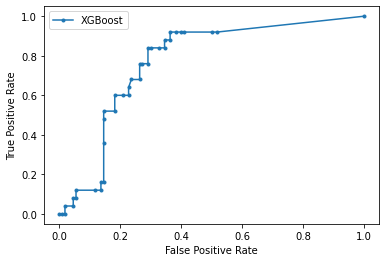

In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

learning_rates = [0.01, 0.03, 0.1]
max_depths = [2, 3, 4, 5, 6]
gammas = [0, .1]
alphas = [0, 0.1, 0.5]
subsamples = [0.5, 0.75, 1]

def fit_xgb_classifier3(df_weight, lr, d, gam, a, sub, spw):
    
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    
    y = df_weight.iloc[:,-1]
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)
       
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)   
    
    
    model = XGBClassifier(max_depth=d, subsample=sub, scale_pos_weight=spw, learning_rate=lr, gamma=gam, 
                          alpha=a, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    
    # predict probabilities
    xgb_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    xgb_probs = xgb_probs[:, 1]
    
    # calculate scores
    xgb_auc = roc_auc_score(y_test, xgb_probs)
    
    # summarize scores
    print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
    
    # calculate roc curves
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
    
    # plot the roc curve for the model
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGBoost')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.savefig('xgboost_auroc.pdf', dpi=300)
    plt.show()
    
    return X_train, X_test, y_train, y_test, model, xgb_auc

X_train, X_test, y_train, y_test, model, xgb_auc = fit_xgb_classifier3(df_weight, 0.01, 4, 0, 0.5, 1, 0.8)

In [55]:
'''
Implementing the Repeated Cross-Validations - 10%
'''
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

def write_shap_dict(df_weight):
    '''
    Function to write the empty dictionary for the SHAP values
    '''
    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y_binary = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y_binary = pd.DataFrame(y_binary)

    
    np.random.seed(31)
    CV_repeats = 10

    # Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
    random_states = np.random.randint(10000, size=CV_repeats) 

    #Dictionary to keep track of the SHAP values of each observation per CV repition
    shap_values_per_cv = {}
    for sample in X.index:
        #create keys for each sample
        shap_values_per_cv[sample] = {}
        #keys for each CV fold within each sample
        for CV_repeat in range(CV_repeats):
            shap_values_per_cv[sample][CV_repeat] = {}
            
    return shap_values_per_cv, random_states
            
shap_values_per_cv, random_states = write_shap_dict(df_weight)

def xgboost_cv(df_weight, lr, d, gam, a, sub, spw, shap_values_per_cv, random_states):
    '''
    Performing the Cross-Validation
    '''

    X = df_weight.iloc[:,:-1]
    X = X.drop(X.columns[X.sum() == 0], axis=1)
    y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
    y = pd.DataFrame(y)
    
    CV_repeats=10

    for i, CV_repeat in enumerate(range(CV_repeats)):
        #Verbose 
        print('\n------------ CV Repeat number:', CV_repeat)

        #Cross-Validations
        CV = KFold(n_splits=5, shuffle=True, random_state = random_states[i])
        ix_training, ix_test = [], []

        #Loop through the CV fold and put the train and test indices into the empty lists above
        for fold in CV.split(df_weight):
            ix_training.append(fold[0])
            ix_test.append(fold[1])
        
        #Loop through outer folds and extract SHAP values
        for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)):
            #Verbose
            print('\n------ Fold Number:',i)

            X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
            y_train, y_test = y.iloc[train_outer_ix], y.iloc[test_outer_ix] #Potential fix for the type of y here


            model = XGBClassifier(max_depth=d, subsample=sub, scale_pos_weight=spw, learning_rate=lr, gamma=gam, 
                          alpha=a, random_state=2)
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
                
            # predict probabilities
            xgb_probs = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            xgb_probs = xgb_probs[:, 1]
            
            # calculate scores
            xgb_auc = roc_auc_score(y_test, xgb_probs)

            # summarize scores
            print('XGBoost: ROC AUC=%.3f' % (xgb_auc))

            # Use SHAP to explain predictions
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)

            # Extract SHAP information per fold per sample 
            for i, test_index in enumerate(test_outer_ix):
                shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
                
    return shap_values_per_cv

shap_values_per_cv = xgboost_cv(df_weight, 0.01, 4, 0, 0.5, 1, 0.8, shap_values_per_cv, random_states)


------------ CV Repeat number: 0

------ Fold Number: 0
XGBoost: ROC AUC=0.668

------ Fold Number: 1
XGBoost: ROC AUC=0.573

------ Fold Number: 2
XGBoost: ROC AUC=0.736

------ Fold Number: 3
XGBoost: ROC AUC=0.683

------ Fold Number: 4
XGBoost: ROC AUC=0.667

------------ CV Repeat number: 1

------ Fold Number: 0
XGBoost: ROC AUC=0.531

------ Fold Number: 1
XGBoost: ROC AUC=0.700

------ Fold Number: 2
XGBoost: ROC AUC=0.668

------ Fold Number: 3
XGBoost: ROC AUC=0.647

------ Fold Number: 4
XGBoost: ROC AUC=0.594

------------ CV Repeat number: 2

------ Fold Number: 0
XGBoost: ROC AUC=0.627

------ Fold Number: 1
XGBoost: ROC AUC=0.652

------ Fold Number: 2
XGBoost: ROC AUC=0.819

------ Fold Number: 3
XGBoost: ROC AUC=0.556

------ Fold Number: 4
XGBoost: ROC AUC=0.590

------------ CV Repeat number: 3

------ Fold Number: 0
XGBoost: ROC AUC=0.680

------ Fold Number: 1
XGBoost: ROC AUC=0.624

------ Fold Number: 2
XGBoost: ROC AUC=0.588

------ Fold Number: 3
XGBoost: ROC 

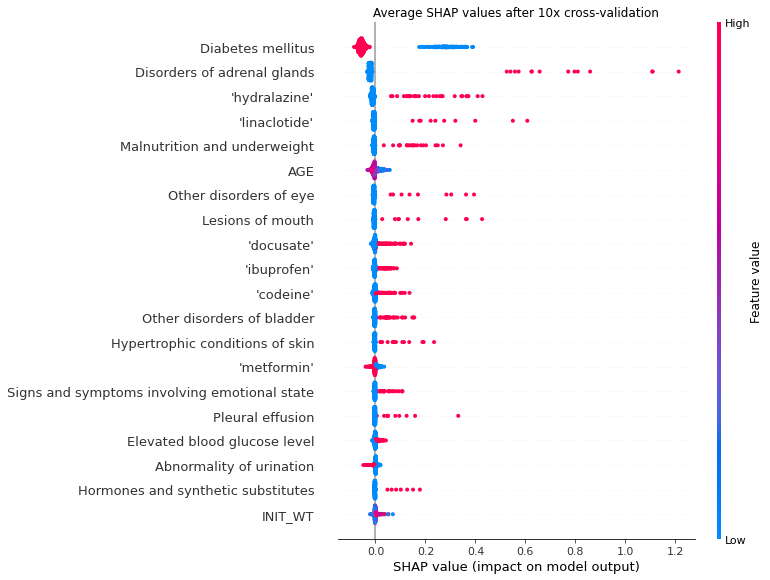

In [56]:
'''
Getting the Shap Plots of the average values from the Cross-Validations
'''
X = df_weight.iloc[:,:-1]
X = X.drop(X.columns[X.sum() == 0], axis=1)
y = [1 if a<-.1 else 0 for a in df_weight.iloc[:,-1]]
y = pd.DataFrame(y)
X = X.rename(columns={"'232'": "Vitamin deficiencies", 
                      "'202'": "Diabetes mellitus", 
                      "'239'": "High Cholesterol", 
                      "'204'": "Elevated blood glucose level",
                      "'256'": "Disorders of fluid, electrolyte and acid-base balance",
                      "'208'": "Disorders of parathyroid gland",
                      "'401'": "Hypertension",
                      "'809'": "Pain",
                      "'713'": "Joint Symptoms",
                      "'337'": "Polyneuropathies",
                      "'236'": "Overweight and obesity",
                      "'211'": "Disorders of adrenal glands",
                      "'374'": "Disorders of the retina",
                      "'389'": "Other disorders of eye",
                      "'977'": "Long term (current) drug therapy",
                      "'164'": "Anemia",
                      "'230'": "Malnutrition and underweight",
                      "'431'": "Stroke and transient cerebral ischemic attacks",
                      "'829'": "Nonspecific findings on examination of blood",
                      "'463'": "Rhinitis and nasal congestion",
                      "'308'": "Signs and symptoms involving emotional state",
                      "'465'": "Pharyngitis",
                      "'507'": "Lesions of mouth",
                      "'801'": "Cough",
                      "'596'": "Other disorders of bladder",
                      "'676'": "Hypertrophic conditions of skin",
                      "'483'": "Pleural effusion",
                      "'594'": "Abnormality of urination",
                      "'961'": "Hormones and synthetic substitutes"
                     })
average_shap_values, stds, ranges = [], [], []

for i in range(0, len(df_weight)):
    # Get all SHAP values for sample number i
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) 
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)


shap.summary_plot(np.array(average_shap_values), X, show = False)
plt.title('Average SHAP values after 10x cross-validation')
plt.savefig('xgboost_cv_shap.pdf', bbox_inches = "tight")

In [2]:
# Install needed packages
!pip install snowflake-connector-python==2.7.7

     |████████████████████████████████| 16.5 MB 13.2 MB/s            
     |████████████████████████████████| 2.1 MB 62.6 MB/s            
     |████████████████████████████████| 194 kB 81.2 MB/s            
     |████████████████████████████████| 105 kB 82.9 MB/s            
  Attempting uninstall: asn1crypto
    Found existing installation: asn1crypto 1.4.0
    Uninstalling asn1crypto-1.4.0:
      Successfully uninstalled asn1crypto-1.4.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [1]:
pip install catboost

     |████████████████████████████████| 98.6 MB 96.1 MB/s            
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install xgboost

     |████████████████████████████████| 255.9 MB 50 kB/s              
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
